<a href="https://colab.research.google.com/github/camen6ert/RRNSin/blob/main/RNNsin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import math

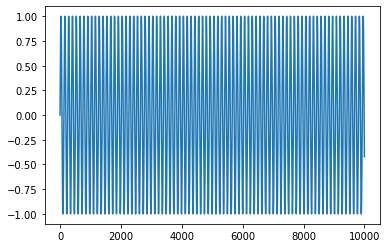

In [9]:
import numpy as np
import matplotlib.pyplot as plt

data = []

for i in range(10000):
  data.append(math.sin(i/20))


plt.plot(data)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

train = []
label = []
seq_len = 5
batch_size = 10

for i in range(len(data)//seq_len):
  tr = data[i:i+seq_len]
  la = data[i+seq_len:i+1+seq_len]

  train_buf = [t for t in tr]
  label_buf = [l for l in la]

  train.append(train_buf)
  label.append(label_buf)

print(train[:5])
print(label[:5])
np_train = np.array(train)
np_label = np.array(label)

print(np_train.shape)
print(np_label.shape)

tensor_x = torch.FloatTensor(np_train)
tensor_y = torch.FloatTensor(np_label)

train_dataset = TensorDataset(tensor_x, tensor_y)
dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True) 

[[0.0, 0.04997916927067833, 0.09983341664682815, 0.14943813247359922, 0.19866933079506122], [0.04997916927067833, 0.09983341664682815, 0.14943813247359922, 0.19866933079506122, 0.24740395925452294], [0.09983341664682815, 0.14943813247359922, 0.19866933079506122, 0.24740395925452294, 0.29552020666133955], [0.14943813247359922, 0.19866933079506122, 0.24740395925452294, 0.29552020666133955, 0.34289780745545134], [0.19866933079506122, 0.24740395925452294, 0.29552020666133955, 0.34289780745545134, 0.3894183423086505]]
[[0.24740395925452294], [0.29552020666133955], [0.34289780745545134], [0.3894183423086505], [0.43496553411123023]]
(2000, 5)
(2000, 1)


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_on_gpu = False

if device == 'cuda':
  train_on_gpu = True

print('Using {} device'.format(device))

Using cuda device


In [12]:

from torch import nn, optim

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, (h, c) = self.rnn(x, self.h1)
        self.h1 = (h.detach(), c.detach())
        out = out[:, -1, :]
        out = self.fc(out) 
        return out

    def init_hidden(self, batch_size, device):
      self.h1 = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

{'epoch': 0, 'loss': 0.4569596815760711}
{'epoch': 1, 'loss': 0.18080607061765752}
{'epoch': 2, 'loss': 0.07037457431334272}
{'epoch': 3, 'loss': 0.03600451395842223}
{'epoch': 4, 'loss': 0.02806073148505547}
{'epoch': 5, 'loss': 0.021069502190630602}
{'epoch': 6, 'loss': 0.020151444939526742}
{'epoch': 7, 'loss': 0.018148197836930578}
{'epoch': 8, 'loss': 0.014816980278961847}
{'epoch': 9, 'loss': 0.01286271490722932}
{'epoch': 10, 'loss': 0.010923378836145933}
{'epoch': 11, 'loss': 0.010504966017751529}
{'epoch': 12, 'loss': 0.009808662694109014}
{'epoch': 13, 'loss': 0.008245961165556395}
{'epoch': 14, 'loss': 0.007800967569741416}
{'epoch': 15, 'loss': 0.007132323591147395}
{'epoch': 16, 'loss': 0.006897570231160729}
{'epoch': 17, 'loss': 0.006230332408668988}
{'epoch': 18, 'loss': 0.006543600970739381}
{'epoch': 19, 'loss': 0.005969895815404235}
{'epoch': 20, 'loss': 0.005287931213095719}
{'epoch': 21, 'loss': 0.0053761647380923564}
{'epoch': 22, 'loss': 0.005494201329306245}
{'ep

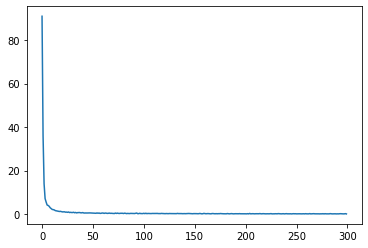

In [13]:
input_size = 1
hidden_size = 5
output_size = 1
num_layers = 2

model = RNNModel(input_size, hidden_size, num_layers, output_size)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

losses = []

for i in range(300):
  myLoss = 0
  k = 0
  model.init_hidden(batch_size, device)

  for idx, (inputs, labels) in enumerate(dataloader):
    inputs = inputs.view(batch_size, seq_len, input_size)
    inputs, labels = inputs.to(device), labels.to(device)

    output = model(inputs)
    loss = criterion(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    myLoss += loss.item()
    k = idx

    #if idx % 1000 == 999:
    # print({ 'epoch': i, 'idx': idx, 'loss': loss.item() })          
  losses.append(myLoss)

  print({ 'epoch': i, 'loss': myLoss/k })

plt.plot(losses)


tensor([[[-0.3718],
         [-0.4177],
         [-0.4626],
         [-0.5064],
         [-0.5488]]])


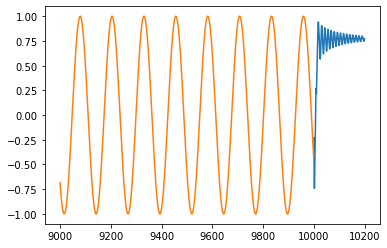

In [22]:
model.eval()

pred_len = 200

data_x = [x for x in range(len(data))]
pred_x = [x for x in range(len(data),len(data)+pred_len)]

inputs = torch.zeros(1, 5, 1)
inputs[0][4][0] = tensor_x[-1][-5]
inputs[0][3][0] = tensor_x[-1][-4]
inputs[0][2][0] = tensor_x[-1][-3]
inputs[0][1][0] = tensor_x[-1][-2]
inputs[0][0][0] = tensor_x[-1][-1]

print(inputs)

model = model.to("cpu")

pred = []

model.init_hidden(1, "cpu")

for i in range(pred_len):
  out = model(inputs)
  out_np = out.detach().numpy()

  for (_,_), p in np.ndenumerate(out_np):
    pred.append(p)

  inputs[0][0][0] = inputs[0][1][0]
  inputs[0][1][0] = inputs[0][2][0]
  inputs[0][2][0] = inputs[0][3][0]
  inputs[0][3][0] = inputs[0][4][0]
  inputs[0][4][0] = out[0][0]


plt.plot(pred_x, pred)
plt.plot(data_x[9000:], data[9000:])